# Heart attack prediction  

### Ce dataset kaggle répertorie 8763 individus à risque d'attaque cardiaque (35%) ou pas (65%).  
### Chaque individu est identifié par :  
-Son patient_ID  
-Son âge, genre, sexe  
-Des données physiologiques  
-Ses habitudes alimentaires  
-Ses habitudes sportives  
-Des données géographiques  

### On va mettre en place un algorithme de classification binaire (risque d'attaque : 1, pas de risque : 0)

# 1 - Import

In [1]:
# General
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pycaret
import kaggle
from time import time

# Data Visualization
import plotly.express as px
import plotly.graph_objs as go
import plotly.subplots as sp
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
from IPython.display import display
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

# Model training
import pycaret as pc
from pycaret.classification import *
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, accuracy_score, recall_score, classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay 
import mlflow
from mlflow.tracking import MlflowClient
from mlflow import set_tracking_uri

In [2]:
t1 = time()

# 2 - Data collection

In [3]:
# Authentification Kaggle
kaggle.api.authenticate()

# Télécharger le dataset depuis Kaggle
kaggle.api.dataset_download_files('iamsouravbanerjee/heart-attack-prediction-dataset', path='.', unzip=True)

In [4]:
data = pd.read_csv(r"C:\Users\John\Desktop\KA-CL-P3-Heart_attack_prediction\heart_attack_prediction_dataset.csv")
data.head()

,Patient ID,Age,Sex,Cholesterol,Blood Pressure,Heart Rate,Diabetes,Family History,Smoking,Obesity,...,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Country,Continent,Hemisphere,Heart Attack Risk
0,BMW7812,67,Male,208,158/88,72,0,0,1,0,...,6.615001,261404,31.251233,286,0,6,Argentina,South America,Southern Hemisphere,0
1,CZE1114,21,Male,389,165/93,98,1,1,1,1,...,4.963459,285768,27.194973,235,1,7,Canada,North America,Northern Hemisphere,0
2,BNI9906,21,Female,324,174/99,72,1,0,0,0,...,9.463426,235282,28.176571,587,4,4,France,Europe,Northern Hemisphere,0
3,JLN3497,84,Male,383,163/100,73,1,1,1,0,...,7.648981,125640,36.464704,378,3,4,Canada,North America,Northern Hemisphere,0
4,GFO8847,66,Male,318,91/88,93,1,1,1,1,...,1.514821,160555,21.809144,231,1,5,Thailand,Asia,Northern Hemisphere,0


# 3 - Cleaning

### On va séparer la colonne 'Blood pressure'  en 'Systolic' et 'Diastolic'

In [5]:
# blood pressure type object => Systolic and Diastolic int
data['Systolic'] = list(map(lambda x : int((x).split('/')[0]), data['Blood Pressure']))
data['Diastolic'] = list(map(lambda x : int((x).split('/')[1]), data['Blood Pressure']))
data.drop(columns='Blood Pressure', inplace=True)

# 4 - Training with pycaret

### Aucun autre préprocessing n'est nécessaire. Pycaret gère automatiquement le hot encoding, les valeurs manquantes, les outliers, les classes déséquilibrées...
### Pycaret va entraîner par stratified cross validation plusieurs modèles.  
### Nous prenons comme indicateur de performance le rappel (recall) qui est le ratio du nombre de prédictions de risque d'attaque correct sur le nombre de risque d'attaque réel.  

In [6]:
# Define an experiment 
mlflow.set_experiment('Heart_Attack')

# Create an MLflow client (don't forget mlflow ui in CLI)
client = MlflowClient()

In [7]:
# loading data for preprocessing
classification_setup = pc.classification.setup(data = data, target  = 'Heart Attack Risk', session_id = 6808)

,Description,Value
0,Session id,6808
1,Target,Heart Attack Risk
2,Target type,Binary
3,Original data shape,"(8763, 27)"
4,Transformed data shape,"(8763, 53)"
5,Transformed train set shape,"(6134, 53)"
6,Transformed test set shape,"(2629, 53)"
7,Ordinal features,2
8,Numeric features,20
9,Categorical features,6


In [8]:
# This function trains all models in the model library and scores them using stratified cross validation for metric evaluation.
# All of the evaluation metrics are cross validated results based on the training set (6134 lines) only
# The parameters are not optimized
best_model = compare_models(sort='Recall', fold=10)
save_model(best_model, 'models/best_model')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
svm,SVM - Linear Kernel,0.4146,0.0000,0.7950,0.2859,0.4205,-0.0018,-0.0065,0.3870
knn,K Neighbors Classifier,0.5796,0.5013,0.2531,0.3735,0.3014,0.0162,0.0171,0.2960
et,Extra Trees Classifier,0.6415,0.4960,0.0014,0.2000,0.0027,0.0001,0.0018,0.4790
lr,Logistic Regression,0.6418,0.4957,0.0000,0.0000,0.0000,0.0000,0.0000,0.9220
nb,Naive Bayes,0.6418,0.5098,0.0000,0.0000,0.0000,0.0000,0.0000,0.2320
dt,Decision Tree Classifier,0.6418,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.2300
ridge,Ridge Classifier,0.6418,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.2410
rf,Random Forest Classifier,0.6418,0.4933,0.0000,0.0000,0.0000,0.0000,0.0000,0.7060
qda,Quadratic Discriminant Analysis,0.6418,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.2290
ada,Ada Boost Classifier,0.6418,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.2410


Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['Age', 'Cholesterol', 'Heart Rate',
                                              'Diabetes', 'Family History',
                                              'Smoking', 'Obesity',
                                              'Alcohol Consumption',
                                              'Exercise Hours Per Week',
                                              'Previous Heart Problems',
                                              'Medication Use', 'Stress Level',
                                              'Sedentary Hours Per Day',
                                              'Income', 'BMI', 'Triglycerides',
                                              'Physical Act...
                  SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                                early_stopping=False,

In [9]:
# This function automatically tunes the hyperparameters of a model on a pre-defined search space and scores it using stratified cross validation
# All of the evaluation metrics are cross validated results based on the training set (6134 lines) only
tuned_best_model = tune_model(best_model)
save_model(best_model, 'models/tuned_best_model')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.3583,0.0000,1.0000,0.3583,0.5276,0.0000,0.0000
1,0.6417,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.6417,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.6417,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.6427,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
5,0.3573,0.0000,1.0000,0.3573,0.5264,0.0000,0.0000
6,0.6427,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
7,0.6411,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
8,0.3589,0.0000,1.0000,0.3589,0.5282,0.0000,0.0000


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['Age', 'Cholesterol', 'Heart Rate',
                                              'Diabetes', 'Family History',
                                              'Smoking', 'Obesity',
                                              'Alcohol Consumption',
                                              'Exercise Hours Per Week',
                                              'Previous Heart Problems',
                                              'Medication Use', 'Stress Level',
                                              'Sedentary Hours Per Day',
                                              'Income', 'BMI', 'Triglycerides',
                                              'Physical Act...
                  SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                                early_stopping=False,

In [10]:
# print to view hyperparamaters
print(tuned_best_model)

SGDClassifier(alpha=1e-07, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.4, fit_intercept=False,
              l1_ratio=0.6500000001, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=-1,
              penalty='elasticnet', power_t=0.5, random_state=6808,
              shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
              warm_start=False)


In [11]:
# predicting the test/hold-out set (2629)
predict_model(tuned_best_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,SVM - Linear Kernel,0.6417,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000


,Patient ID,Age,Sex,Cholesterol,Heart Rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,...,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Country,Continent,Hemisphere,Systolic,Diastolic,Heart Attack Risk,prediction_label
1923,YNM3561,62,Female,175,70,0,0,1,0,0,...,319,1,5,Brazil,South America,Southern Hemisphere,121,77,1,0
604,TWT7891,41,Male,217,49,1,1,1,1,1,...,344,7,4,United Kingdom,Europe,Northern Hemisphere,128,97,0,0
5713,XEY9152,64,Female,132,72,1,0,1,1,1,...,311,7,5,Argentina,South America,Southern Hemisphere,141,92,1,0
8089,LJT4093,57,Male,171,109,0,0,1,1,1,...,128,4,6,South Korea,Asia,Northern Hemisphere,98,62,1,0
3955,NSF7490,29,Male,144,73,1,1,1,1,1,...,488,2,9,India,Asia,Northern Hemisphere,166,102,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3693,RAY7371,24,Male,335,82,0,0,1,0,1,...,507,2,5,Vietnam,Asia,Northern Hemisphere,90,100,1,0
7149,CKJ2104,39,Male,127,87,0,0,1,0,1,...,303,0,4,Australia,Australia,Southern Hemisphere,123,106,1,0
8336,JVY6000,58,Male,319,40,1,1,1,1,0,...,485,0,6,Nigeria,Africa,Northern Hemisphere,158,102,1,0
1765,ANR6991,79,Male,138,88,1,1,1,0,0,...,594,4,5,Germany,Europe,Northern Hemisphere,135,68,1,0


In [12]:
# The finalize_model() function fits the model onto the complete dataset including the test/hold-out sample
final_model = finalize_model(tuned_best_model)
save_model(final_model,'models/final_model')
evaluate_model(final_model)

Transformation Pipeline and Model Successfully Saved


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

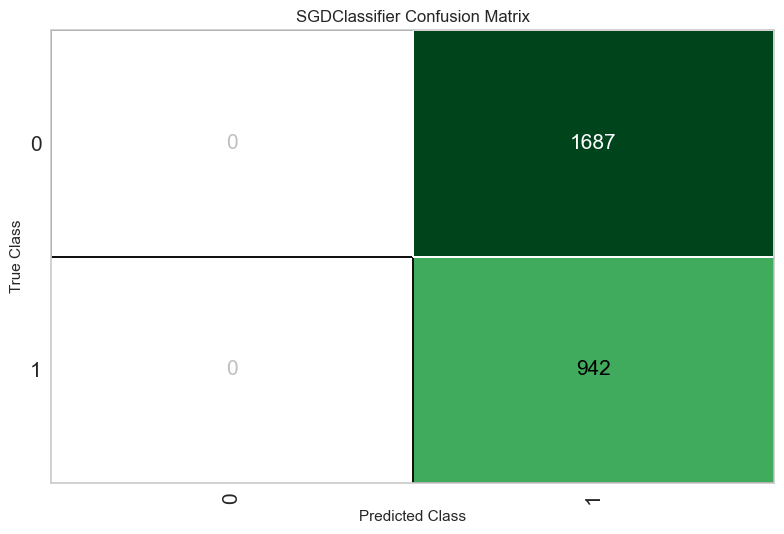

In [23]:
plot_model(final_model, plot='confusion_matrix')

### Le meilleur modèle est le SGDClassifier avec un recall de 1 sur les données de test mais la classe 1 a aspiré toute les prédictions ! On peut certainement faire mieux en blendant les 5 meilleurs modèles. 

In [14]:
%%time
top5 = compare_models(n_select=5,sort='Recall')
tuned_top5 = [tune_model(i, optimize='Recall') for i in top5]
blend_model = blend_models(tuned_top5, optimize='Recall')
save_model(blend_model,'models/blend_model')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
svm,SVM - Linear Kernel,0.4146,0.0000,0.7950,0.2859,0.4205,-0.0018,-0.0065,0.3070
knn,K Neighbors Classifier,0.5796,0.5013,0.2531,0.3735,0.3014,0.0162,0.0171,0.2590
et,Extra Trees Classifier,0.6415,0.4960,0.0014,0.2000,0.0027,0.0001,0.0018,0.4900
lr,Logistic Regression,0.6418,0.4957,0.0000,0.0000,0.0000,0.0000,0.0000,0.2410
nb,Naive Bayes,0.6418,0.5098,0.0000,0.0000,0.0000,0.0000,0.0000,0.2180
dt,Decision Tree Classifier,0.6418,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1960
ridge,Ridge Classifier,0.6418,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1940
rf,Random Forest Classifier,0.6418,0.4933,0.0000,0.0000,0.0000,0.0000,0.0000,0.6330
qda,Quadratic Discriminant Analysis,0.6418,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.2080
ada,Ada Boost Classifier,0.6418,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1900


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.3583,0.0000,1.0000,0.3583,0.5276,0.0000,0.0000
1,0.3583,0.0000,1.0000,0.3583,0.5276,0.0000,0.0000
2,0.3583,0.0000,1.0000,0.3583,0.5276,0.0000,0.0000
3,0.3583,0.0000,1.0000,0.3583,0.5276,0.0000,0.0000
4,0.6427,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
5,0.6427,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.6427,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
7,0.6411,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
8,0.3589,0.0000,1.0000,0.3589,0.5282,0.0000,0.0000


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5505,0.4896,0.3409,0.3641,0.3521,0.0085,0.0086
1,0.5342,0.4833,0.3727,0.3565,0.3644,-0.0029,-0.0029
2,0.5554,0.4997,0.3727,0.3779,0.3753,0.0302,0.0302
3,0.5358,0.4795,0.3409,0.3488,0.3448,-0.0145,-0.0145
4,0.5253,0.4819,0.3516,0.3407,0.3461,-0.0264,-0.0264
5,0.5139,0.4791,0.3470,0.3290,0.3378,-0.0458,-0.0459
6,0.5416,0.5085,0.3607,0.3591,0.3599,0.0029,0.0029
7,0.5171,0.4765,0.3591,0.3376,0.3480,-0.0348,-0.0349
8,0.5530,0.5182,0.3636,0.3738,0.3687,0.0228,0.0228


Fitting 10 folds for each of 10 candidates, totalling 100 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.3583,0.5000,1.0000,0.3583,0.5276,0.0000,0.0000
1,0.3583,0.5000,1.0000,0.3583,0.5276,0.0000,0.0000
2,0.3583,0.5000,1.0000,0.3583,0.5276,0.0000,0.0000
3,0.3583,0.5000,1.0000,0.3583,0.5276,0.0000,0.0000
4,0.3573,0.5000,1.0000,0.3573,0.5264,0.0000,0.0000
5,0.3573,0.5000,1.0000,0.3573,0.5264,0.0000,0.0000
6,0.3573,0.5000,1.0000,0.3573,0.5264,0.0000,0.0000
7,0.3589,0.5000,1.0000,0.3589,0.5282,0.0000,0.0000
8,0.3589,0.5000,1.0000,0.3589,0.5282,0.0000,0.0000


Fitting 10 folds for each of 10 candidates, totalling 100 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.3583,0.4994,1.0000,0.3583,0.5276,0.0000,0.0000
1,0.4495,0.4762,0.5909,0.3439,0.4348,-0.0333,-0.0380
2,0.3583,0.4982,1.0000,0.3583,0.5276,0.0000,0.0000
3,0.4609,0.4693,0.4591,0.3227,0.3790,-0.0722,-0.0758
4,0.3573,0.5279,1.0000,0.3573,0.5264,0.0000,0.0000
5,0.3573,0.5064,1.0000,0.3573,0.5264,0.0000,0.0000
6,0.3573,0.4965,1.0000,0.3573,0.5264,0.0000,0.0000
7,0.3589,0.5002,1.0000,0.3589,0.5282,0.0000,0.0000
8,0.4535,0.4807,0.5864,0.3458,0.4351,-0.0299,-0.0339


Fitting 10 folds for each of 10 candidates, totalling 100 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6417,0.5276,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.6417,0.5131,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.6417,0.4951,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.6417,0.4941,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.6427,0.5213,0.0000,0.0000,0.0000,0.0000,0.0000
5,0.6427,0.5360,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.6427,0.5191,0.0000,0.0000,0.0000,0.0000,0.0000
7,0.6411,0.5526,0.0000,0.0000,0.0000,0.0000,0.0000
8,0.6411,0.4762,0.0000,0.0000,0.0000,0.0000,0.0000


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.3583,0.0000,1.0000,0.3583,0.5276,0.0000,0.0000
1,0.4186,0.0000,0.7227,0.3495,0.4711,-0.0231,-0.0312
2,0.5554,0.0000,0.3727,0.3779,0.3753,0.0302,0.0302
3,0.4365,0.0000,0.6727,0.3507,0.4611,-0.0189,-0.0235
4,0.3573,0.0000,1.0000,0.3573,0.5264,0.0000,0.0000
5,0.3573,0.0000,1.0000,0.3573,0.5264,0.0000,0.0000
6,0.3573,0.0000,1.0000,0.3573,0.5264,0.0000,0.0000
7,0.5171,0.0000,0.3591,0.3376,0.3480,-0.0348,-0.0349
8,0.4209,0.0000,0.7227,0.3510,0.4725,-0.0206,-0.0277


Transformation Pipeline and Model Successfully Saved
CPU times: total: 26.4 s
Wall time: 4min 9s


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['Age', 'Cholesterol', 'Heart Rate',
                                              'Diabetes', 'Family History',
                                              'Smoking', 'Obesity',
                                              'Alcohol Consumption',
                                              'Exercise Hours Per Week',
                                              'Previous Heart Problems',
                                              'Medication Use', 'Stress Level',
                                              'Sedentary Hours Per Day',
                                              'Income', 'BMI', 'Triglycerides',
                                              'Physical Act...
                                                                   class_weight='balanced',
                                         

In [15]:
final_blend_model = finalize_model(blend_model)
save_model(final_blend_model,'models/final_blend_model')
evaluate_model(final_blend_model)

Transformation Pipeline and Model Successfully Saved


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

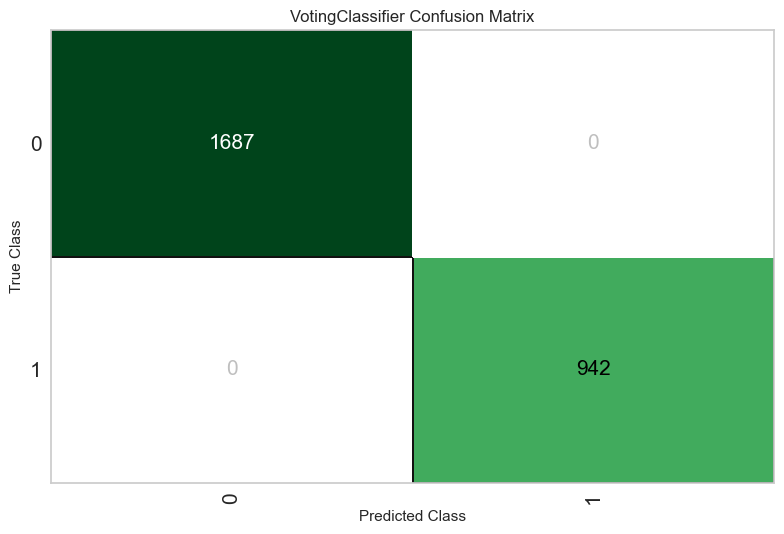

In [21]:
plot_model(final_blend_model,plot='confusion_matrix')

### Ce dernier modèle obtient une accuracy parfaite de 1 sur l'échantillon de test !

In [33]:
# Create an MLflow client (don't forget mlflow ui in CLI)
client = MlflowClient()

mlflow.set_experiment('Heart_Attack_1')
with mlflow.start_run():
    run = mlflow.active_run()
    # Constructing a dataset from a Pandas DataFrame
    dataset = mlflow.data.from_pandas(data)
    # Logging dataset input	
    mlflow.log_input(dataset)
    with mlflow.start_run(run_name="Best_Model", nested=True):
        run = mlflow.active_run()
        predict_model(best_model)
        mlflow.log_metric('Recall', pull()[['Recall']].iloc[0,0])
        plot_model(best_model, plot='confusion_matrix', save = True)
        mlflow.log_artifact(r"C:\Users\John\Desktop\KA-CL-P3-Heart_attack_prediction\Confusion Matrix.png", "artifacts")
        client.log_artifact(run.info.run_id, 'models/best_model.pkl') 
    with mlflow.start_run(run_name="Tuned_Best_Model", nested=True):
        run = mlflow.active_run()
        predict_model(tuned_best_model)
        mlflow.log_metric('Recall', pull()[['Recall']].iloc[0,0])
        plot_model(tuned_best_model, plot='confusion_matrix', save = True)
        mlflow.log_artifact(r"C:\Users\John\Desktop\KA-CL-P3-Heart_attack_prediction\Confusion Matrix.png", "artifacts")
        client.log_artifact(run.info.run_id, 'models/tuned_best_model.pkl')
    with mlflow.start_run(run_name="Final_Model", nested=True):
        run = mlflow.active_run()
        predict_model(final_model)
        mlflow.log_metric('Recall', pull()[['Recall']].iloc[0,0])
        plot_model(final_model, plot='confusion_matrix', save = True)
        mlflow.log_artifact(r"C:\Users\John\Desktop\KA-CL-P3-Heart_attack_prediction\Confusion Matrix.png", "artifacts")
        client.log_artifact(run.info.run_id, 'models/final_model.pkl')
    with mlflow.start_run(run_name="Blend_Model", nested=True):
        run = mlflow.active_run()
        predict_model(blend_model)
        mlflow.log_metric('Recall', pull()[['Recall']].iloc[0,0])      
        plot_model(blend_model, plot='confusion_matrix', save = True)
        mlflow.log_artifact(r"C:\Users\John\Desktop\KA-CL-P3-Heart_attack_prediction\Confusion Matrix.png", "artifacts")
        client.log_artifact(run.info.run_id, 'models/blend_model.pkl')
    with mlflow.start_run(run_name="Final_Blend_Model", nested=True):
        run = mlflow.active_run()
        predict_model(final_blend_model)
        mlflow.log_metric('Recall', pull()[['Recall']].iloc[0,0])      
        plot_model(final_blend_model, plot='confusion_matrix', save = True)
        mlflow.log_artifact(r"C:\Users\John\Desktop\KA-CL-P3-Heart_attack_prediction\Confusion Matrix.png", "artifacts")
        client.log_artifact(run.info.run_id, 'models/final_blend_model.pkl')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,SVM - Linear Kernel,0.3583,0.5000,1.0000,0.3583,0.5276,0.0000,0.0000


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,SVM - Linear Kernel,0.6417,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,SVM - Linear Kernel,0.3583,0.5000,1.0000,0.3583,0.5276,0.0000,0.0000


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.3583,0.5000,1.0000,0.3583,0.5276,0.0000,0.0000


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


In [ ]:
print('notebook duration : ',(time()-t1)/60,'minutes')

# 5 - Création d'une API de prédiction de risque d'attaque

In [34]:
create_api(best_model, "heart_attack_api")
#!python heart_attack_api.py

API successfully created. This function only creates a POST API, it doesn't run it automatically. To run your API, please run this command --> !python heart_attack_api.py


### Activer l'api Fastapi en executant l'instruction 'python heart_attack_api.py' dans la CLI
### L'interface utilisateur de l'API est disponible en local à l'adresse 'http://localhost:8000/docs'